In [1]:
import math
import torch

device = torch.device("cuda")

max_seq_len = 128


In [2]:
class Embedding(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        out = self.embed(x)
        return out

In [3]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim
        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (2 * i / self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (2 * (i + 1) / self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)       # pre-calculate and freeze

    def forward(self, x):
        seq_len = x.size(1)
        return x * math.sqrt(self.embed_dim) + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        # return x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)

In [4]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.single_head_dim = self.embed_dim // self.num_heads   # 512 / 8 = 64, every head takes its part of the input
        self.query_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)  # a big matrix for the whole input
        self.key_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)    # we will split the heads later on
        self.value_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.mixer = torch.nn.Linear(self.embed_dim, self.embed_dim)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V shapes are (batch x length x single_head_dim) == (32 x 10 x 64)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.single_head_dim)
        # scores shape is (batch x length x length) == (32 x 10 x 10)
        if mask is not None:
            scores = scores.masked_fill(mask == False, -1e9)    # put large negative numbers to positions where mask == False
        probs = torch.softmax(scores, dim=-1)                   # transform scores to probabilities (B x L x L)
                                                                # for each sample in the batch tell how ith token is important to jth token
        return torch.matmul(probs, V)                           # re-weigh values according to the probabilities

    def split_heads(self, x):
        batch_size, seq_length, embed_dim = x.size()            # B x L x D
        assert self.embed_dim == embed_dim
        return x.view(                                          # B x L x H x d
            batch_size,
            seq_length,
            self.num_heads,
            self.single_head_dim,
        ).transpose(1, 2)                                       # B x H x L x d
        
    def combine_heads(self, x):
        batch_size, num_heads, seq_length, single_head_dim = x.size()
        assert self.num_heads == num_heads
        assert self.single_head_dim == single_head_dim
        # B x H x L x d   => 
        # B x L x H x d   =>
        # B x L x D
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.query_matrix(Q))
        K = self.split_heads(self.key_matrix(K))
        V = self.split_heads(self.value_matrix(V))        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.mixer(self.combine_heads(attn_output))

In [5]:
class FeedForward(torch.nn.Module):
    def __init__(self, embed_dim, expansion):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(embed_dim, embed_dim * expansion)
        self.fc2 = torch.nn.Linear(embed_dim * expansion, embed_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # expand => non-linearity => shrink
        return self.fc2(self.relu(self.fc1(x)))

In [6]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, expansion)
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        # (attention => droupout) + residual => norm
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        # (MLP => dropout) + residual => norm
        return self.norm2(x + self.dropout(self.feed_forward(x)))

In [7]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, expansion)
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.norm3 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # self attention (decoder x decoder)
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        # cross attention (decoder x encoder), note that queries are from decoder, keys and values - from encoder
        x = self.norm2(x + self.dropout(self.cross_attn(x, encoder_output, encoder_output, src_mask)))
        # MLP + dropout + residual + norm
        return self.norm3(x + self.dropout(self.feed_forward(x)))

In [8]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, expansion, max_seq_length, dropout):
        super(EncoderDecoder, self).__init__()
        # we could split encoder and decoder embeddings
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(embed_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, expansion, max_seq_length, dropout):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.layers = torch.nn.ModuleList([EncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(embed_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src):
        mask = (src != 0).unsqueeze(1).unsqueeze(3)
        seq_length = src.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(src.device)
        mask = mask & nopeak_mask
        return mask

    def forward(self, src):
        mask = self.generate_mask(src)
        embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        for layer in self.layers:
            embedded = layer(embedded, mask)
        return self.fc(embedded)

In [10]:
import requests

all_shakespeare = requests.get("https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt").content.decode()
print(len(all_shakespeare))

5458199


In [11]:
dictionary = ["<empty>", "<start>", "<end>"] + list(set(all_shakespeare))
print(dictionary)
print(len(dictionary))

sym2idx = {s: i for i, s in enumerate(dictionary)}
print(sym2idx)

['<empty>', '<start>', '<end>', 'H', '"', 'X', 'n', '|', '.', 'L', '!', '7', '*', 'K', '/', 'E', '4', '5', 'd', '2', ':', 'g', '3', '0', ' ', 'x', 'h', '(', '>', 'o', '9', 'p', '_', 'M', 'i', '@', 'W', "'", 'B', 'b', 'e', ']', 'I', '~', 'a', 'F', 'l', 'C', '<', 'Y', 'z', 'j', '\n', 'm', 'u', '`', 'y', '=', '#', '1', 'O', 'N', ')', 't', 'c', ';', '[', 'T', '}', '%', 'R', 'w', '6', '?', 'G', '-', 'P', 'U', ',', 'q', 's', '8', '&', 'r', 'f', 'Z', 'A', 'D', 'V', 'S', 'J', 'Q', 'k', 'v']
94
{'<empty>': 0, '<start>': 1, '<end>': 2, 'H': 3, '"': 4, 'X': 5, 'n': 6, '|': 7, '.': 8, 'L': 9, '!': 10, '7': 11, '*': 12, 'K': 13, '/': 14, 'E': 15, '4': 16, '5': 17, 'd': 18, '2': 19, ':': 20, 'g': 21, '3': 22, '0': 23, ' ': 24, 'x': 25, 'h': 26, '(': 27, '>': 28, 'o': 29, '9': 30, 'p': 31, '_': 32, 'M': 33, 'i': 34, '@': 35, 'W': 36, "'": 37, 'B': 38, 'b': 39, 'e': 40, ']': 41, 'I': 42, '~': 43, 'a': 44, 'F': 45, 'l': 46, 'C': 47, '<': 48, 'Y': 49, 'z': 50, 'j': 51, '\n': 52, 'm': 53, 'u': 54, '`': 5

In [12]:
import random

random.seed(42)

#data = all_shakespeare.split("\n\n")
#data = list(filter(lambda x: x and len(x) < max_seq_len, data))
data = [all_shakespeare[i:i+max_seq_len-1] for i in range(0, len(all_shakespeare), max_seq_len)]
random.shuffle(data)

print(len(data))
print(data[77])
print(len(data[77]))

42643
If the tagrag people did not clap him and hiss him
    according as he pleased and displeased them, as they use to do
    the p
127


In [13]:
train = [data[i] for i in range(len(data)) if i % 10 != 0]
test = [data[i] for i in range(len(data)) if i % 10 == 0]

print(train[-5])
print("")
print(test[-5])

 both together heav'd it up,
    We'll both together lift our heads to heaven,
    And never more abase our sight so low
    As

thee.
  PRINCESS OF FRANCE. Honey, and milk, and sugar; there is three.
  BEROWNE. Nay, then, two treys, an if you grow so nice


In [14]:
src = torch.tensor([[1, 2, 3, 0]]).to(device)
model = Encoder(len(dictionary), 256, 8, 8, 4, max_seq_len, 0.1).to(device)
mask = model.generate_mask(src)
print(mask)
print(sum(p.numel() for p in model.parameters()))

tensor([[[[ True, False, False, False],
          [ True,  True, False, False],
          [ True,  True,  True, False],
          [False, False, False, False]]]], device='cuda:0')
6360158


In [15]:
import numpy as np

def generate(model, len_limit):
    model.eval()
    with torch.no_grad():
        result = ["<start>"] + list("Caesar:")
        while len(result) < len_limit:
            x = torch.tensor([[sym2idx[x] for x in result]]).to(device)
            y = model(x)
            y = y[0][-1].cpu().numpy()
            y = np.exp(y)
            y /= np.sum(y)
            #print(" ".join(map(lambda t: "{:.4f}".format(t), y)) + "\n")
            x = dictionary[np.random.choice(y.shape[0], p = y)]
            if x in ["<start>", "<end>", "<empty>"]:
                break
            result.append(x)
        return ''.join(result[1:])

print(generate(model, max_seq_len))

Caesar:


100%|██████████| 4265/4265 [00:02<00:00, 1559.49it/s]


Epoch 0 loss: 3.24995 3.21202
Caesar: eeDIOmrmoeo



100%|██████████| 4265/4265 [00:02<00:00, 1559.54it/s]


Epoch 1 loss: 2.44881 2.09128
Caesar: trars,
    The I co I fown omod murs
    Greingen of and the you.
   MOMERCEPrt



100%|██████████| 4265/4265 [00:02<00:00, 1558.87it/s]


Epoch 2 loss: 2.04469 1.77701
Caesar:
     By the notilds that the set you kiss;
      What is treet he chowse and him. Which hyre datercue;
    In make epec



100%|██████████| 4265/4265 [00:02<00:00, 1560.01it/s]


Epoch 3 loss: 1.83493 1.67251
Caesar: or to out
   teagiaty a of tell my leget, my proved-sow
   Way, as madatin inking so horrmain, and but in sin to.
 



100%|██████████| 4265/4265 [00:02<00:00, 1560.16it/s]


Epoch 4 loss: 1.79621 1.56203
Caesar:
  Beliss-leck as I grace; he mask, he'll-by so this aughtess. O, hent, how w



100%|██████████| 4265/4265 [00:02<00:00, 1559.04it/s]


Epoch 5 loss: 1.64953 1.48926
Caesar: Celies four in you wity.
  HELEN. Feelles, and birturge
   vow to lay with sudy.
  YORK. You say are he clain me.
  Lar



100%|██████████| 4265/4265 [00:02<00:00, 1559.95it/s]


Epoch 6 loss: 1.55180 1.45478
Caesar:
       When is clott's mind fory by his liet nand,
                    Re-enter whiter princes.
  DEDEK EWARDY, mady Du



100%|██████████| 4265/4265 [00:02<00:00, 1560.55it/s]


Epoch 7 loss: 1.56352 1.39742
Caesar: which you?
  OTHELLO. Prayines! we promize- on, shring?
  OCTHELLO. Well I wild spoke you will for you advage.

  Ben. 



100%|██████████| 4265/4265 [00:02<00:00, 1560.62it/s]


Epoch 8 loss: 1.47003 1.36951
Caesar: John.
    This is the fielding, Apiton, cast of his la suffe,
    My fronow maters, Allbury, undertergct in consent.
  



100%|██████████| 4265/4265 [00:02<00:00, 1560.65it/s]


Epoch 9 loss: 1.43707 1.35032
Caesar: my lord!
  Ben. What, came?
  To marry that, as the me sender was 'tis court.
  W



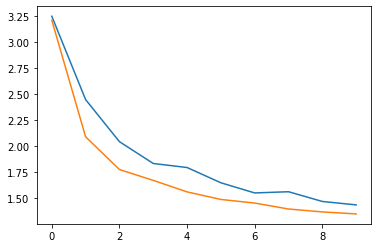

In [16]:
import matplotlib.pyplot as plt
import tqdm


def iterate_batches(data, batch_size, device):
    x, y, max_len = [], [], 0
    for k in tqdm.tqdm(range(len(data))):
        item = data[k]
        x.append([sym2idx[sym] for sym in ["<start>"] + list(item)])
        y.append([sym2idx[sym] for sym in list(item) + ["<end>"]])
        max_len = max(max_len, len(x[-1]))
        if len(x) == batch_size or k + 1 == len(data):
            for i in range(len(x)):
                x[i] = x[i] + [sym2idx["<empty>"] for _ in range(max_len - len(x[i]))]
                y[i] = y[i] + [sym2idx["<empty>"] for _ in range(max_len - len(y[i]))]
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            yield x, y
            x, y, max_len = [], [], 0
        

def train_epoch(data, model):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.AdamW(model.parameters())
    total_loss, total_count = 0.0, 1e-38
    random.shuffle(data)
    for inputs, answers in iterate_batches(data, 256, device):
        optimizer.zero_grad()
        #print(inputs.shape)
        #print(answers.shape)
        outputs = model(inputs)
        #print(outputs.shape)
        outputs = outputs.transpose(1, 2)
        #print(outputs.shape)
        #print("")
        loss = loss_function(outputs, answers)
        total_loss += (loss.item() * inputs.shape[0])
        total_count += inputs.shape[0]
        loss.backward()
        optimizer.step()
    return total_loss / total_count

def test_epoch(data, model):
    with torch.no_grad():
        model.eval()
        loss_function = torch.nn.CrossEntropyLoss()
        total_loss, total_count = 0.0, 1e-38
        for inputs, answers in iterate_batches(data, 256, device):
            outputs = model(inputs)
            outputs = outputs.transpose(1, 2)
            loss = loss_function(outputs, answers)
            total_loss += (loss.item() * inputs.shape[0])
            total_count += inputs.shape[0]
        return total_loss / total_count

train_losses, test_losses = [], []
for i in range(10):
    train_loss = train_epoch(train, model)
    test_loss = test_epoch(test, model)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Epoch {} loss: {:.5f} {:.5f}".format(i, train_loss, test_loss))
    print(generate(model, max_seq_len))
    print("")
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()